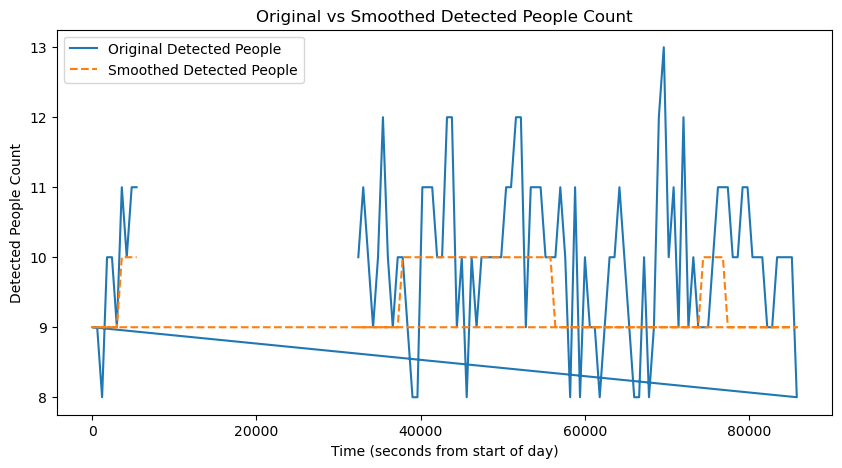

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# 1. 데이터 로드
# 파일 경로를 지정하고 데이터프레임으로 불러옵니다
file_path = '/Users/a0000/Desktop/cafe 1 data.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')
df.columns = ['date', 'time', 'detected_people']  # 컬럼명 지정

# 2. 시간 변환
# 'time' 열을 초 단위로 변환합니다. 예: 09:00:00 -> 32400 (초)
df['date'] = pd.to_datetime(df['date'])  # 날짜를 datetime 형식으로 변환
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds().astype(int)  # 시간 컬럼을 초 단위로 변환

# 3. Gaussian smoothing
# 'detected_people' 값에 대한 Gaussian smoothing을 적용하여 변동성을 줄입니다
sigma = 10  # 스무딩 강도
df['detected_people_smooth'] = gaussian_filter1d(df['detected_people'], sigma)

# 4. Min-Max 스케일링
# 스무딩된 값을 0과 1 사이의 값으로 정규화하여 모델에 입력하기 적합하게 변환합니다
scaler_people = MinMaxScaler(feature_range=(0, 1))
df['scaled_people'] = scaler_people.fit_transform(df[['detected_people_smooth']])

# 5. 데이터 시각화
# 스무딩 전후의 'detected_people'을 비교하여 변동성이 얼마나 줄어들었는지 확인합니다
plt.figure(figsize=(10, 5))
plt.plot(df['time'][:100], df['detected_people'][:100], label='Original Detected People')
plt.plot(df['time'][:100], df['detected_people_smooth'][:100], label='Smoothed Detected People', linestyle='--')
plt.xlabel('Time (seconds from start of day)')
plt.ylabel('Detected People Count')
plt.legend()
plt.title('Original vs Smoothed Detected People Count')
plt.show()


In [8]:
# 학습 데이터 준비

# 예측을 위한 시간 창과 예측 시간 설정
time_window = 200      # 모델 입력에 사용할 과거 데이터의 범위 (200개의 연속된 데이터)
prediction_time = 1200  # 예측할 미래 시간 간격 (초 단위)

# 학습 데이터와 타겟 값 준비
x_train, y_train = [], []

# 주어진 시간 창과 예측 시간을 사용하여 학습 데이터 생성
for i in range(time_window, len(df) - prediction_time):
    x_train.append(df['scaled_people'].iloc[i - time_window:i].values)  # 과거 데이터
    y_train.append(df['scaled_people'].iloc[i + prediction_time])       # 예측할 값

# 학습 데이터를 numpy 배열로 변환하여 모델 입력에 적합하게 준비
x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (1571, 200)
y_train shape: (1571, 1)


In [9]:
# 필요한 패키지 가져오기
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model  # Model 가져오기
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# 학습 데이터 차원 맞추기
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # (batch_size, time_window, 1) 형태로 변경

# Attention 기반 모델 정의
class SimpleAttentionModel(Model):
    def __init__(self, units, **kwargs):
        super(SimpleAttentionModel, self).__init__(**kwargs)
        self.units = units
        self.lstm = layers.LSTM(units, return_sequences=True)  # LSTM 레이어
        self.attention_dense = layers.Dense(1, activation='tanh')  # Attention 가중치 계산
        self.flatten = layers.Flatten()  # 가중합 계산 후 평탄화
        self.dense = layers.Dense(1)     # 최종 예측값 산출

    def call(self, inputs):
        lstm_out = self.lstm(inputs)  # LSTM 출력
        attention_weights = self.attention_dense(lstm_out)  # Attention 가중치
        weighted_output = attention_weights * lstm_out      # 가중치를 곱한 출력
        output = self.flatten(weighted_output)              # 평탄화
        return self.dense(output)                           # 최종 출력

# 모델 초기화 및 컴파일
model = SimpleAttentionModel(units=100)
model.compile(loss=MeanSquaredLogarithmicError(), optimizer='adam')

# 임시로 데이터 일부로 모델 초기화 및 학습 (1번 에포크)
model.fit(x_train[:10], y_train[:10], epochs=1, batch_size=1, verbose=1)

# 모델 구조 출력
print("Model structure:")
model.summary()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0988
Model structure:


Model: "simple_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (1, 200, 100)          │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 200, 1)            │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 20000)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,708 (713.71 KB)

 Trainable params: 60,902 (237.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 121,806 (475.81 KB)

In [10]:
# x_train 데이터 차원 조정
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # (batch_size, time_window, 1) 형태로 변경

# 모델 학습
# 학습은 3 epoch 동안, 배치 크기는 10으로 설정합니다
model.fit(x_train, y_train, epochs=3, batch_size=10, verbose=1)

# 예측 생성
# 예측 데이터로 사용할 마지막 부분을 validation set으로 가정합니다
valid = df['scaled_people'][-(len(x_train) + prediction_time):].values
X_test = np.array([valid[i - time_window:i].reshape(time_window, 1) for i in range(time_window, len(valid) - prediction_time)])

# 예측 수행
predicted_values = model.predict(X_test)
predicted_values = scaler_people.inverse_transform(predicted_values)  # 스케일링 복원


Epoch 1/3
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0370
Epoch 2/3
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0217
Epoch 3/3
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0180
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


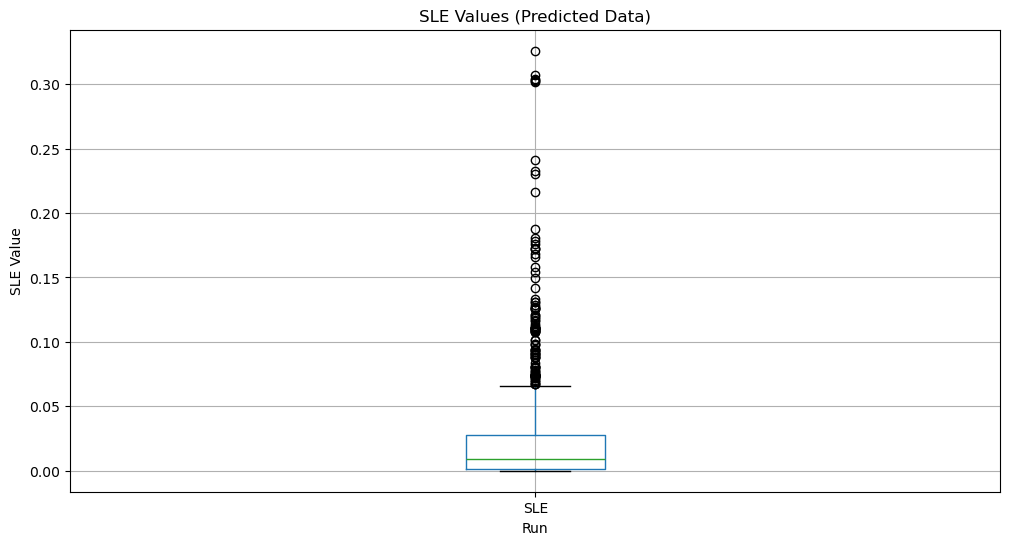

평균 SLE: 0.022364928862801555
중앙값 SLE: 0.008765803031181527
상위 25% SLE: 0.027722543918930028
하위 25% SLE: 0.001643124350585878
이상치 개수: 106


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 검증 데이터와 예측 데이터의 SLE(Squared Log Error) 계산
# 'detected_people'의 실제 값과 예측값 'predicted_values'의 차이를 계산합니다.
SLE = np.square(np.log1p(df['detected_people'][-len(predicted_values):].values) - np.log1p(predicted_values.flatten()))

# SLE를 DataFrame으로 변환하고 CSV 파일로 저장
SLE_df = pd.DataFrame({'SLE': SLE})
SLE_df.to_csv('/Users/a0000/Desktop/SLE_values3.csv', index=False)  # 파일 저장 경로 설정

# SLE 시각화 (박스플롯)
plt.figure(figsize=(12, 6))
SLE_df.boxplot()
plt.title("SLE Values (Predicted Data)")
plt.xlabel("Run")
plt.ylabel("SLE Value")
plt.show()

# SLE 값의 통계 정보 계산
Q1 = SLE_df['SLE'].quantile(0.25)
Q3 = SLE_df['SLE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
num_outliers = ((SLE_df['SLE'] < lower_bound) | (SLE_df['SLE'] > upper_bound)).sum()

# 통계 정보 DataFrame에 저장
statistics_df = pd.DataFrame({
    'Mean': [SLE_df['SLE'].mean()],
    'Median': [SLE_df['SLE'].median()],
    'Upper 25%': [Q3],
    'Lower 25%': [Q1],
    'Number of Outliers': [num_outliers]
})
statistics_df.to_csv('/Users/a0000/Desktop/SLE_statistics3.csv', index=False)  # 파일 저장 경로 설정

print(f"평균 SLE: {SLE.mean()}")
print(f"중앙값 SLE: {np.median(SLE)}")
print(f"상위 25% SLE: {Q3}")
print(f"하위 25% SLE: {Q1}")
print(f"이상치 개수: {num_outliers}")
